In [ ]:
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile("/content/data-v3.zip", 'r')
zip_ref.extractall("data/")
zip_ref.close()

In [ ]:
train_path = '/content/data/train'
test_path = '/content/data/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
# # Buat generator untuk augmentasi data train
# train_datagen = ImageDataGenerator(
#     # rescale=1.0 / 255,
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='reflect',
#     brightness_range=[0.8, 1.2],
# )

# test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# train_generator = train_datagen.flow_from_directory(
#     train_path,
#     target_size=(224, 224),
#     batch_size=30,
#     color_mode = 'rgb',
#     class_mode='categorical'
# )

# validation_generator = test_datagen.flow_from_directory(
#     test_path,
#     target_size=(224, 224),
#     batch_size=30,
#     color_mode = 'rgb',
#     class_mode='categorical'
# )


train_datagen = ImageDataGenerator(
    shear_range=0.2,
    rotation_range=30,
    fill_mode='reflect',
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],  # Mengatur rentang kecerahan gambar
    channel_shift_range=20,  # Menggeser nilai kanal warna secara acak
)

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=30,
    color_mode='rgb'
)

Found 935 images belonging to 13 classes.
Found 234 images belonging to 13 classes.


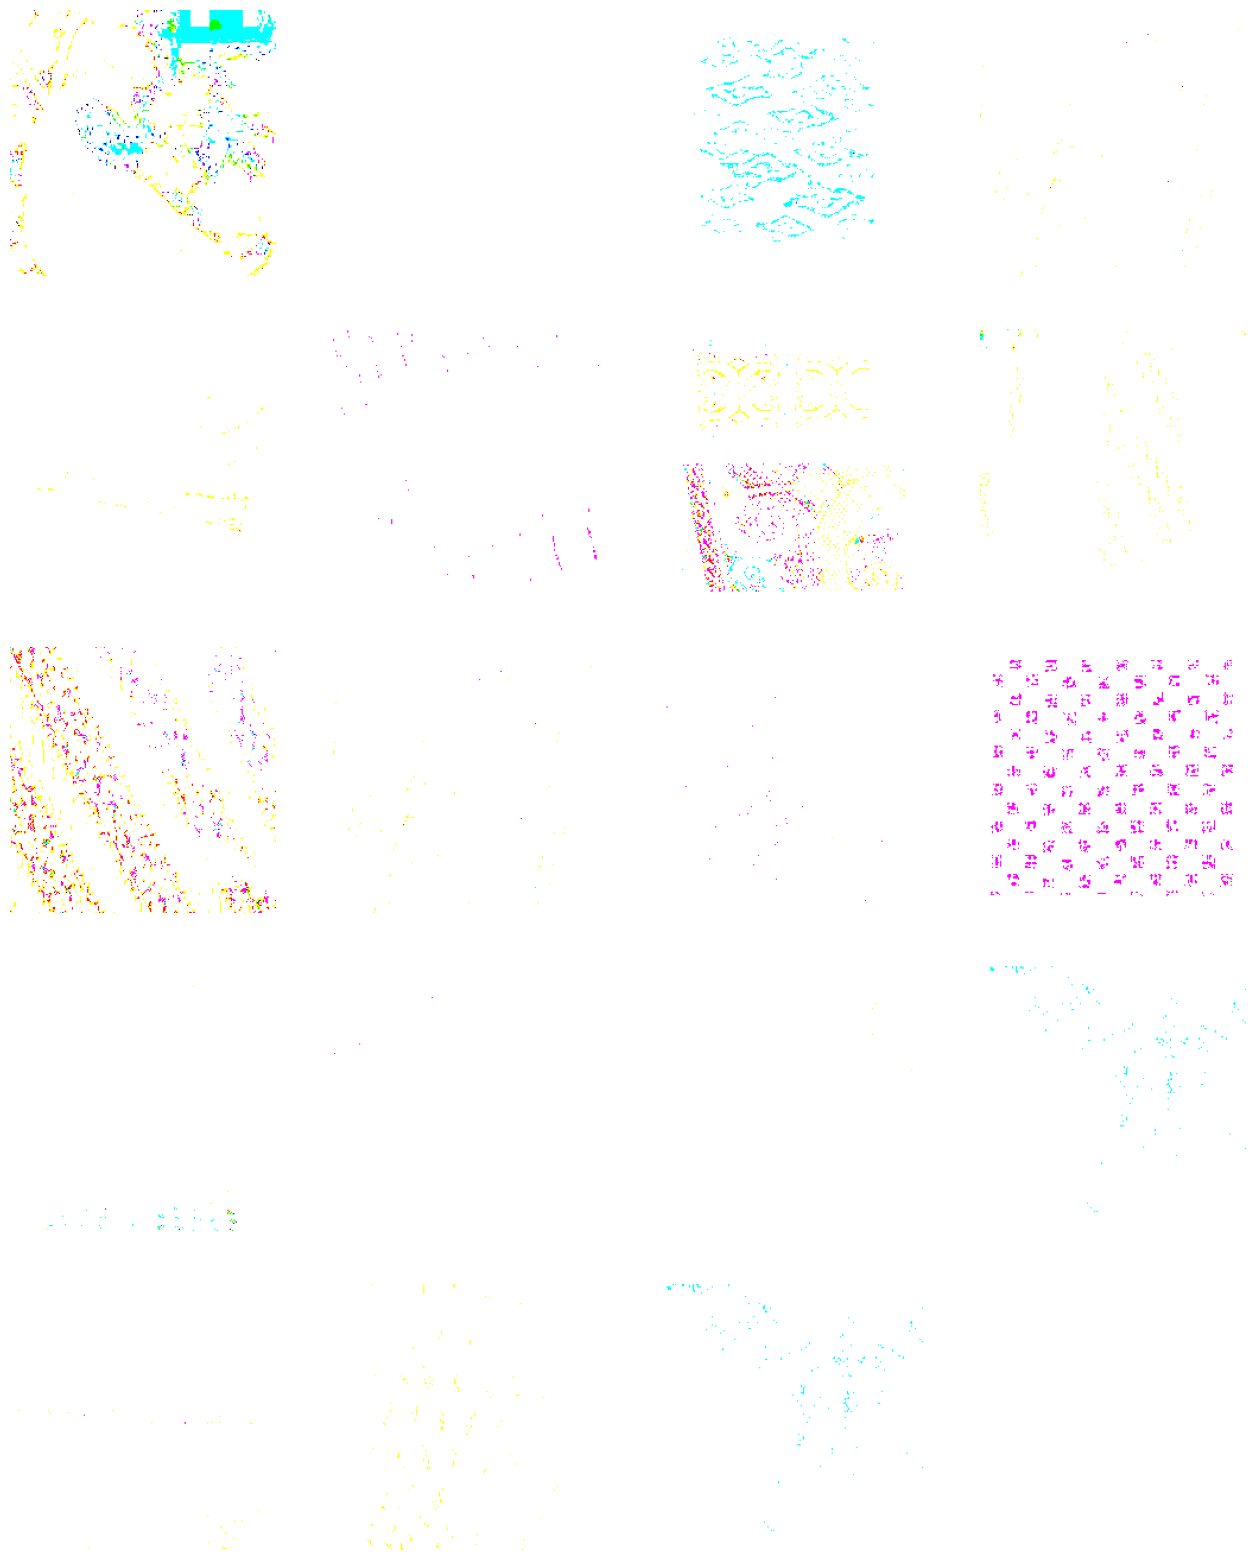

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 20))

for i in range(20):
    img, label = validation_generator.next()
    plt.subplot(5, 4, i+1)
    plt.imshow(img[0])
    plt.axis('off')
    
plt.show()

In [ ]:
all_motif = train_generator.class_indices
x = 1
for motiif in all_motif:
  print(x,'.',motiif)
  x = x+1

1 . Batik Cendrawasih
2 . Batik Dayak
3 . Batik Geblek Renteng
4 . Batik Ikat Celup
5 . Batik Insang
6 . Batik Kawung
7 . Batik Lasem
8 . Batik Megamendung
9 . Batik Pala
10 . Batik Parang
11 . Batik Poleng
12 . Batik Sekar Jagad
13 . Batik Tambal


In [ ]:
print(len(train_generator.class_indices))

13


In [ ]:
# from tensorflow.keras.applications import NASNetMobile
# !pip install MobileNetV3
from tensorflow.keras.applications import MobileNetV3Large

# base_model = NASNetMobile(
#     include_top=False,
#     weights='imagenet',
#     input_shape=(224, 224, 3),
#     pooling='avg'
# )

# base_model = NASNetMobile(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights="imageneat",
#     pooling='avg',
# )
input = (224,224, 3)
base_model = MobileNetV3Large(
    input_shape=input,
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
base_model.trainable = False

In [ ]:
print(train_generator.samples)
print(validation_generator.samples)

935
234


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Memantau metrik val_accuracy
    patience=0,  # Jumlah epoch yang harus melewati tanpa peningkatan sebelum berhenti
    mode='max',  # Mode 'max' untuk mencari peningkatan val_accuracy
    baseline=0.84  # Nilai val_accuracy yang diinginkan untuk berhenti
)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

model = Sequential([
    base_model,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(13, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.summary()

tensorboard_callback = TensorBoard(log_dir='logs')

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=train_generator.samples // 30,
    validation_steps=validation_generator.samples // 30,
    shuffle = True,
    epochs=50,
    callbacks=[tensorboard_callback]
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 dense_9 (Dense)             (None, 64)                61504     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

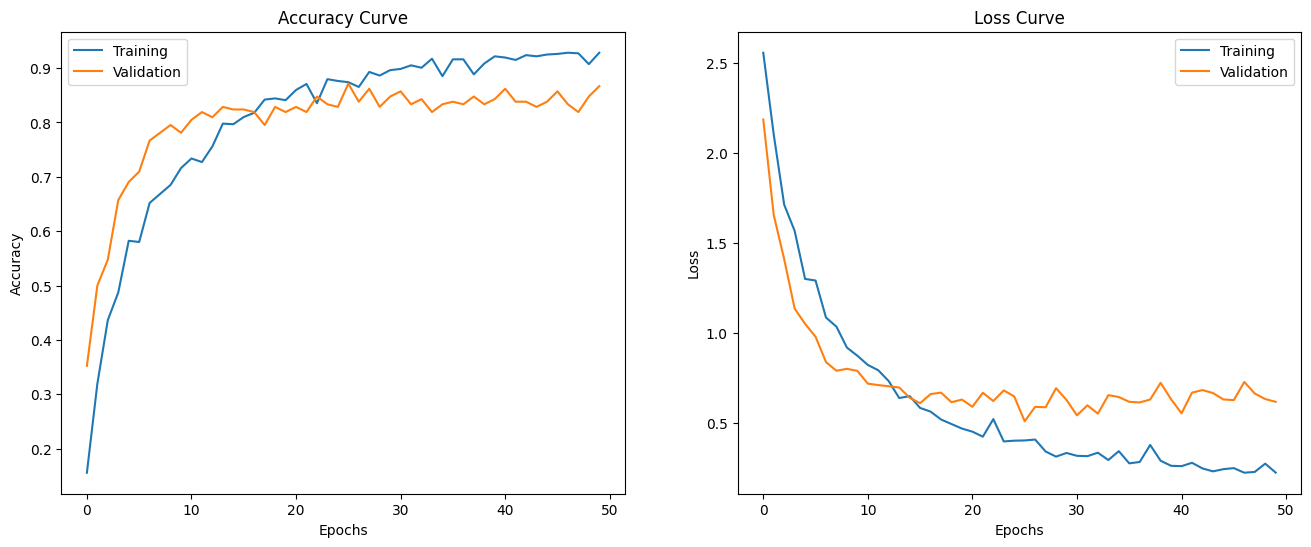

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
# Evaluasi Model
scores = model.evaluate(validation_generator)
print(f"Test Accuracy: {scores[1]*100:.2f}%")

8/8 [==============================] - 7s 886ms/step - loss: 0.6163 - accuracy: 0.8718
Test Accuracy: 87.18%


In [ ]:
def predict_motif(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    img_array /= 255.0

    predictions = model.predict(img_array)
    motif_index = tf.argmax(predictions, axis=1).numpy()[0]
    motif_label = list(validation_generator.class_indices.keys())[motif_index]

    return motif_label

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
def predict_motif(image_path,batik_type):
  motive = batik_type
  images_list = os.listdir(os.path.join(test_path, motive))    

  correct_count = 0
  # for idx, image in enumerate(images_list):
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  motives_list = list(train_generator.class_indices.keys())
  prediction = model(img_array)
  pred_idx = np.argmax(prediction)
  pred_motive = motives_list[pred_idx]
  pred_confidence = prediction[0][pred_idx] * 100
  print(pred_motive)
  print('\n\n')
  return pred_motive


def count_correct_predictions(test_folder):
    batik_types = [
        "Batik Cendrawasih",
        "Batik Dayak",
        "Batik Geblek Renteng",
        "Batik Ikat Celup",
        "Batik Insang",
        "Batik Kawung",
        "Batik Lasem",
        "Batik Megamendung",
        "Batik Pala",
        "Batik Parang",
        "Batik Poleng",
        "Batik Sekar Jagad",
        "Batik Tambal"
    ]

    correct_predictions_per_folder = {}

    for batik_type in batik_types:
        folder_path = os.path.join(test_folder, batik_type)
        if os.path.isdir(folder_path):
            correct_predictions = 0
            total_images = 0
            for file in os.listdir(folder_path):
                if file.endswith(".jpg") or file.endswith(".png"):
                    image_path = os.path.join(folder_path, file)
                    print("Seharusnya ", batik_type,'Dan Model Machine Learning memprediksi : ')
                    if batik_type == predict_motif(image_path,batik_type):
                        correct_predictions += 1
                    total_images += 1
            correct_predictions_per_folder[batik_type] = (correct_predictions, total_images)

    return correct_predictions_per_folder

# Contoh penggunaan fungsi
test_folder = "/content/data/test"
correct_predictions_per_folder = count_correct_predictions(test_folder)

for batik_type, (correct_predictions, total_images) in correct_predictions_per_folder.items():
    print(f"Subfolder: {batik_type}")
    print(f"Total Correct Predictions: {correct_predictions}")
    print(f"Total Images: {total_images}")
    print("------------")


Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Dayak



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Lasem



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cendrawasih



Seharusnya  Batik Cendrawasih Dan Model Machine Learning memprediksi : 
Batik Cend

In [ ]:
def predict_motif2(image_path):  

  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  motives_list = list(train_generator.class_indices.keys())
  prediction = model(img_array)
  pred_idx = np.argmax(prediction)
  pred_motive = motives_list[pred_idx]
  pred_confidence = prediction[0][pred_idx] * 100
  print(pred_motive)
  print('\n\n')
  return pred_motive

In [ ]:
from google.colab import files
from IPython.display import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
gambar = files.upload()
image_path = next(iter(gambar))
print(predict_motif2(image_path))

Saving WhatsApp Image 2023-06-05 at 13.38.32.jpg to WhatsApp Image 2023-06-05 at 13.38.32.jpg
Batik Kawung



Batik Kawung


In [ ]:
export_dir = 'saved_model/1'

tf.saved_model.save(model, export_dir)

In [ ]:
# Select mode of optimization
optimization = tf.lite.Optimize.DEFAULT

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)

# Set the optimzations
converter.optimizations = [optimization]

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()

In [ ]:
import pathlib

In [ ]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

3358248

In [ ]:

model_save_path = "saved_model3/"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
modelConv = converter.convert()

# Save the model.
os.makedirs('modelFolder')
with open('modelFolder/model.tflite', 'wb') as f:
  f.write(modelConv)

adam optimizer mendapatkan acc 77.8 , saat test image betul 210/270</br>
sgd optimizer mendapatkan acc 72, saat test image betul 195/270</br>
RMSprop overfit bgt